In [50]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import os
import gc
import time
import warnings
from warnings import simplefilter
from itertools import combinations

import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from catboost import EFeaturesSelectionAlgorithm, EShapCalcType
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
is_offline = False    # Flag for online/offline mode
is_train = True    # Flag for training mode
is_infer = True    # Flag for inference mode
split_day = 435    # Split day for time series data

In [58]:
train = pd.read_csv("train.csv")

In [59]:
train.head(20)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001,0,0_0_8
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.0,7.970333,0,0_0_9


In [60]:
num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  5237980
Number of Columns:  17


In [61]:
train = train.dropna(subset=["target"])

# 🔁 Reset the index of the DataFrame and apply the changes in place
train.reset_index(drop=True, inplace=True)

num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  5237892
Number of Columns:  17


In [62]:
pos_changes = train['reference_price'].diff().clip(lower=1)
neg_changes = train['reference_price'].diff().clip(upper=1)

train['RSI'] = 1 - (100/(1 + pos_changes/neg_changes))

In [63]:
#train['date_id'] = pd.to_datetime(train['date_id'])

In [64]:
# Define the window size for the moving average
window_size = 2
# Compute the moving averages for each stock and the 'wap' column
train['SMA'] = train.groupby('stock_id')['wap'].transform(lambda x: x.rolling(window=window_size,  min_periods=1).mean())

In [65]:
daily_wap_sum = train.groupby('date_id')['wap'].sum()
rows_per_day = train.groupby('date_id').size()

overall_average_wap = daily_wap_sum / rows_per_day

train = train.merge(overall_average_wap.reset_index(name='daily_average_wap'), on='date_id', how='left')

In [66]:
#⚡Optiver 🚀Robust Best ⚡ Single Model features

train["volume"] = train.eval("ask_size + bid_size")
train["mid_price"] = train.eval("(ask_price + bid_price) / 2")
train["liquidity_imbalance"] = train.eval("(bid_size-ask_size)/(bid_size+ask_size)")
train["matched_imbalance"] = train.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
train["size_imbalance"] = train.eval("bid_size / ask_size")
train["price_spread"] = train["ask_price"] - train["bid_price"]
train['market_urgency'] = train['price_spread'] * train['liquidity_imbalance']

In [67]:
train.head(20)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,RSI,SMA,daily_average_wap,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,NaN,1.0,1.000021,69144.53,0.999919,0.754340,-0.615890,7.141326,0.000214,1.614287e-04
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,0.991601,1.0,1.000021,23838.13,1.000278,-0.728751,-0.815787,0.156905,0.000764,-5.567654e-04
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,...,1.033511,1.0,1.000021,56951.00,0.999850,0.332935,-0.714567,1.998210,0.000895,2.979771e-04
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,0.939037,1.0,1.000021,481357.30,1.000107,-0.990340,-0.213547,0.004853,0.000215,-2.129231e-04
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,1.063941,1.0,1.000021,16919.64,0.999705,0.948687,-0.951109,37.976365,0.000622,5.900832e-04
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,...,0.889822,1.0,1.000021,7610.37,1.000207,-0.484199,-1.000000,0.347529,0.000856,-4.144739e-04
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,...,1.052027,1.0,1.000021,10473.64,0.999895,0.272368,-0.579870,1.748641,0.000777,2.116296e-04
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,...,1.029709,1.0,1.000021,7709.80,0.999935,0.333160,-0.386262,1.999222,0.000389,1.295994e-04
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,...,0.990201,1.0,1.000021,54180.96,0.999532,0.919922,-0.596417,23.975550,0.001019,9.374002e-04
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,...,0.894811,1.0,1.000021,12390.00,1.000000,-0.000646,-0.345503,0.998709,0.001292,-8.342211e-07


In [68]:
train.tail(20)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,RSI,SMA,daily_average_wap,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
5237872,180,480,540,563043.09,-1,0.998141,6.717567e+06,0.996492,0.996767,0.997866,...,0.785362,0.997853,0.999562,43080.02,0.998004,0.361296,-0.845331,2.131339,0.000275,0.000099
5237873,181,480,540,498430.75,1,1.001248,1.384217e+07,1.001527,1.001304,1.001081,...,0.690262,1.000977,0.999562,61060.32,1.001193,-0.958833,-0.930487,0.021016,0.000223,-0.000214
5237874,182,480,540,2685032.08,1,0.999491,3.848839e+07,1.000210,1.000210,0.999311,...,1.176009,0.999431,0.999562,344639.36,0.999401,0.219214,-0.869575,1.561522,0.000180,0.000039
5237875,183,480,540,571821.88,-1,0.996694,9.752797e+07,0.996468,0.996468,0.996694,...,1.280485,0.996718,0.999562,103384.11,0.996750,-0.615091,-0.988342,0.238321,0.000113,-0.000070
5237876,184,480,540,283509.38,1,0.996650,1.590741e+07,0.998372,0.997156,0.996447,...,1.004400,0.996506,0.999562,138955.61,0.996549,-0.084319,-0.964979,0.844476,0.000203,-0.000017
5237877,185,480,540,3018493.53,-1,1.000057,2.723894e+07,0.997937,0.998915,1.000029,...,0.660457,1.000314,0.999562,255106.09,1.000165,-0.769175,-0.800479,0.130470,0.000272,-0.000209
5237878,186,480,540,2106025.88,-1,0.999780,1.988346e+07,0.998713,0.998713,0.999780,...,1.027708,0.999818,0.999562,691699.59,0.999856,-0.494699,-0.808452,0.338062,0.000153,-0.000076
5237879,187,480,540,3791745.66,1,0.999641,3.380628e+07,1.000641,1.000564,0.999564,...,1.013902,0.999632,0.999562,97820.38,0.999602,-0.508661,-0.798301,0.325679,0.000077,-0.000039
5237880,188,480,540,18930.38,-1,0.999741,6.465049e+06,0.999741,0.999741,0.999741,...,0.990001,0.999899,0.999562,334446.86,1.000019,-0.299220,-0.994161,0.539385,0.000556,-0.000166
5237881,189,480,540,956757.96,1,1.000715,3.710938e+07,1.001167,1.001054,1.000602,...,0.902695,1.000691,0.999562,837960.32,1.000659,0.881619,-0.949732,15.894634,0.000113,0.000100


In [69]:
offline_train = train[train["date_id"] <= split_day]
offline_test = train[train["date_id"] > split_day]
print("Offline mode")
print(f"train : {offline_train.shape}, valid : {offline_test.shape}")

Offline mode
train : (4742893, 27), valid : (494999, 27)


In [73]:
columns_to_drop = ['row_id', 'far_price', 'near_price']
train = train.drop(columns_to_drop, axis=1)  # Replace 'your_target_column' with the actual target column name
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = train.dropna()  

train.reset_index(drop=True, inplace=True)

num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

ValueError: Found input variables with inconsistent numbers of samples: [2343564, 5237892]

In [41]:
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,...,RSI,SMA,daily_average_wap,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
0,0,0,300,0.00,0,1.000241,26670118.88,1.000026,19319.31,1.000241,...,1.056131,1.000266,1.000021,35468.86,1.000134,0.089367,-1.000000,1.196275,0.000215,0.000019
1,1,0,300,242332.96,-1,1.000073,3242054.27,0.999544,43205.40,1.000308,...,1.016803,1.000180,1.000021,45248.16,0.999926,0.909709,-0.860904,21.150502,0.000764,0.000695
2,2,0,300,0.00,0,1.000193,4671376.00,0.999035,18971.00,1.001036,...,0.988001,0.999671,1.000021,78659.26,1.000036,-0.517641,-1.000000,0.317835,0.002001,-0.001036
3,3,0,300,2914730.16,1,0.999870,41057776.66,0.999827,25569.50,1.000042,...,1.032310,0.999948,1.000021,63467.00,0.999935,-0.194243,-0.867429,0.674701,0.000215,-0.000042
4,4,0,300,3396923.02,1,0.998496,38356174.88,0.998357,14446.00,0.998703,...,1.137589,0.998458,1.000021,17047.18,0.998530,0.694826,-0.837285,5.553633,0.000346,0.000240


Setting up training and testing data

In [75]:
columns_to_drop = ['target']
X = train.drop(columns_to_drop, axis=1)  # Replace 'your_target_column' with the actual target column name
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MemoryError: Unable to allocate 719. MiB for an array with shape (18, 5237892) and data type float64

Linear Regression Error for comparison

In [43]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions using Linear Regression
y_pred_linear = linear_model.predict(X_test)

# Evaluate Linear Regression
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error for Linear Regression: {mse_linear}')

Mean Squared Error for Linear Regression: 68.67073857477008


Catboost fitting

In [44]:
catboost_model = CatBoostRegressor(iterations=200, depth=10, learning_rate=0.05, loss_function='RMSE', random_seed=42)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

0:	learn: 8.3661345	test: 8.3759156	best: 8.3759156 (0)	total: 386ms	remaining: 1m 16s
10:	learn: 8.3007263	test: 8.3138613	best: 8.3138613 (10)	total: 3.9s	remaining: 1m 6s
20:	learn: 8.2614464	test: 8.2803350	best: 8.2803350 (20)	total: 7.53s	remaining: 1m 4s
30:	learn: 8.2369513	test: 8.2618150	best: 8.2618150 (30)	total: 11s	remaining: 1m
40:	learn: 8.2172526	test: 8.2471589	best: 8.2471589 (40)	total: 14.8s	remaining: 57.5s
50:	learn: 8.1995572	test: 8.2354012	best: 8.2354012 (50)	total: 18.6s	remaining: 54.3s
60:	learn: 8.1801228	test: 8.2224522	best: 8.2224522 (60)	total: 22.4s	remaining: 51.1s
70:	learn: 8.1651152	test: 8.2126482	best: 8.2126482 (70)	total: 26.1s	remaining: 47.4s
80:	learn: 8.1506910	test: 8.2042142	best: 8.2042142 (80)	total: 29.7s	remaining: 43.7s
90:	learn: 8.1393024	test: 8.1964423	best: 8.1964423 (90)	total: 33.6s	remaining: 40.2s
100:	learn: 8.1284775	test: 8.1899197	best: 8.1899197 (100)	total: 37s	remaining: 36.3s
110:	learn: 8.1169921	test: 8.1827827	b

Catboost error

In [45]:
y_pred = catboost_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 66.19156594667633


Column Importance

In [46]:
feature_importances = catboost_model.get_feature_importance()
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                    Feature  Importance
2         seconds_in_bucket   12.311583
22           market_urgency   11.547123
4   imbalance_buy_sell_flag   10.029858
6              matched_size    7.434451
21             price_spread    7.402761
15        daily_average_wap    6.415053
19        matched_imbalance    5.138915
12                  time_id    4.405302
13                      RSI    4.076843
0                  stock_id    3.865300
7                 bid_price    3.859118
1                   date_id    3.675428
9                 ask_price    2.965452
3            imbalance_size    2.664114
11                      wap    2.532255
17                mid_price    2.068367
16                   volume    1.994740
8                  bid_size    1.984591
5           reference_price    1.619745
10                 ask_size    1.597727
14                      SMA    1.039096
20           size_imbalance    0.788827
18      liquidity_imbalance    0.583350


Attempting to get SHAP to work

In [57]:
columns_to_drop = ['target', 'far_price', 'near_price']
feature_name = train.columns.drop(['target']).tolist()

# Feature selection using SHAP values
# Create Pool object with both features (X) and target variable (y)
train_pool = Pool(X_train, label=y_train)

# Feature selection using SHAP values
summary = ctb_model.select_features(
    train_pool,  # Pass the Pool object that includes both features and target variable
    eval_set=[(X_test, y_test)],
    features_for_select=feature_name,
    num_features_to_select=len(feature_name) - 24,  # Dropping from 124 to 100
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

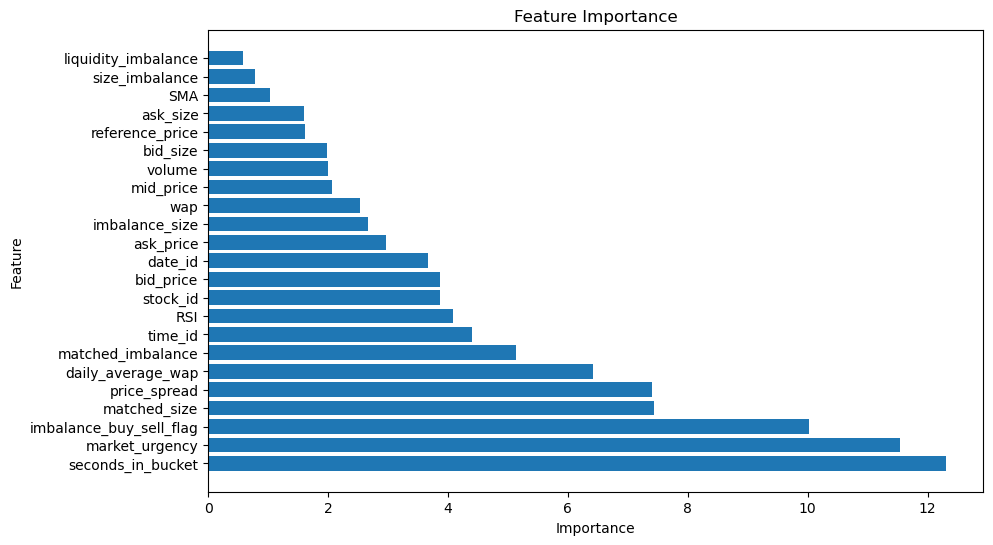

In [47]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()